# This notebook is solely for Twitter scraping

Previous keyword searches:

  - `happy OR sad OR life OR death`
  - `stocks OR money OR taxes`
  - `politics OR government OR Trump`
  - ` ` (left blank)
  - `music OR tunes OR dance`
  - `love OR peace OR hate OR war`

Still to do:
- `"data science" OR coding OR programming`

# Define your query here:

In [2]:
query = "'data science' OR coding OR programming"
year = 2018
csv_filename = f'tweets_coding_{year}.csv'

### Import Libraries

In [1]:
# for scraping the web
import requests
from twitterscraper import query_tweets
import twitterscraper

# file management
import csv
import json
import subprocess
# import os
import shutil
from textblob import TextBlob 

import re
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'}


# Defining several functions to automate scraping and processing

In [3]:
def make_dates_list(year=2018):
    # define a list of dates for a given year
    dates_year = [str(date)[:10] for date in pd.date_range(start=f'1/1/{year}', end=f'12/31/{year}')]
    # define a list of dates for generating file names    
    dates_stripped_year = [date.replace('-','') for date in dates_year]
    return dates_year, dates_stripped_year


def scrape_tweets(query, year=2018, num_tweets=1000):
    """
    Automatically scrapes X number of Tweets per day for a given
    year. Scraping works backwards from midnight.
    'query' must be a string
    """
    dates_year, dates_stripped_year = make_dates_list(year)
    for i in range(len(dates_year)):
        begin_date = dates_year[i]
        if i == len(dates_year)-1:
            end_date = f'{year+1}-01-01'
        else:
            end_date = dates_year[i+1]
        day = dates_stripped_year[i]
        cmd = 'twitterscraper "{}" -l {} -o t{}.json -bd {} -ed {} --lang en'.format(query, 
                num_tweets, day, begin_date, end_date)
        subprocess.run(cmd)

        #move JSON file into `data` directory
        shutil.move(f't{day}.json', f'./data/t{day}.json')
        if (i+1)%5 == 0:
            print(f"finished scraping {i+1} days of {year}")
    print("SCRAPING PROCESS COMPLETE!")
    pass

In [4]:
# Let's define sets of old-school emoticons and emojis
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [5]:
# Define functions to clean tweets and get tweet sentiment

# portions of the code below comes from :
# https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf
def replace_emoticons(tweet):
    "This code replaces happy and sad emoticons with the words 'HAPPY' and 'SAD'"
    rhappy = '[' + re.escape(''.join(emoticons_happy)) + ']'
    re.sub(rhappy, ' HAPPY ', tweet)
    rsad = '[' + re.escape(''.join(emoticons_sad)) + ']'
    re.sub(rsad, ' SAD ', tweet)
    return tweet

def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, usernames, and
    special characters using simple regex statements. 
    '''
    tweet = replace_emoticons(tweet)
    # p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)
    # tweet = p.clean(tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) \
                            |(\w+:\/\/\S+)", " ", tweet).split())
    return tweet

def double_clean_tweet(tweet):
    "This function goes a little further than the previous clean function"
    #removing mentions
    tweet = re.sub(r':', ' ', tweet)
    tweet = re.sub(r'‚Ä¶', ' ', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet  (unless you want to later go through the UNICODE
    # charts and separate "happy" emojis from "sad" emojis and add them to 
    # the `replace_emoticons()` function)
    tweet = emoji_pattern.sub(r'', tweet)
    return tweet


# Sentiment analysis code below adapted from:
# https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet)
    # set sentiment 
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity
    if analysis.sentiment.polarity > 0.1: 
        sentiment = 'positive'
    elif analysis.sentiment.polarity < -0.1: 
        sentiment = 'negative'
    else: 
        sentiment = 'neutral'
    return sentiment, polarity, subjectivity

In [6]:
# define a function to create a .CSV file that compiles the relevant 
# info from the JSONs, preprocesses the tweets, and performs sentiment analysis
def json_to_csv_tweets(output_filename='output.csv', year=2018):
    """
    Takes in JSON files of scraped tweets from the `./data/` folder,
    cleans the tweets, performs sentiment analysis, and then outputs
    the results to the provided destination CSV filename.
    """
    # create the csv writer object
    csvwriter = csv.writer(open(output_filename, 'w', newline=''))
    csvwriter.writerow(["timestamp", "text", "sentiment", "polarity", "subjectivity", "tally"])

    # iterate adding rows of JSON to the CSV file
    dates_year, dates_stripped_year = make_dates_list(year)
    for i in dates_stripped_year:
        f = open(f'./data/t{i}.json')
        data = json.load(f)
        for tweet in data:
            tw = tweet["text"]
            tw = replace_emoticons(tw)
            tw = clean_tweet(tw)
            tw = double_clean_tweet(tw)
            sentiment, polarity, subjectivity = get_tweet_sentiment(tw)
            csvwriter.writerow([i, tw, sentiment, polarity, subjectivity, 1])
        f.close()
        if float(i)%20 == 0:
            print(f"Finished working with:   ./data/t{i}.json")
    print("JOB IS COMPLETELY FINISHED.  HOORAY!!")
    pass

In [7]:
# define a funcation to plot sentiment trends
def plot_sentiments(csv_filename='tweets.csv', year=2018, positive_only=False):
    # check to see if scraper worked on all dates; a few missing dates is OK
    tweets_df = pd.read_csv(csv_filename)
    tweets_df.timestamp = pd.to_datetime(tweets_df.timestamp, format='%Y%m%d')
    grouped1 = pd.DataFrame(tweets_df.groupby(['timestamp'])['tally'].sum())
    grouped1 = grouped1.sort_values(by=['tally'])
    display(grouped1.head(10))

    # plotting sentiment trends
    grouped = pd.DataFrame(tweets_df.groupby(['timestamp', 'sentiment'])['tally'].sum()).reset_index()
    if positive_only:
        temp_df = grouped[grouped.sentiment == 'positive'].set_index('timestamp')
        temp_df['tally'].plot(figsize=(15,8), label=csv_filename)
        plt.ylabel("Number of Positive Tweets\n(~1,000/day total)", fontsize=16)
        plt.xlabel(f"Keyword search: '{query}''", fontsize=16)
        plt.title(f"Daily Positivity at midnight (UTC) in {year}", fontsize=20)
    else:
        for sentiment in grouped.sentiment.unique():
            temp_df = grouped[grouped.sentiment == sentiment].set_index('timestamp')
            temp_df['tally'].plot(figsize=(15,8), label=sentiment)
            plt.ylabel("Number of Tweets by Sentiment\n(~1,000/day total)", fontsize=16)
            plt.xlabel(f"Keyword search: '{query}''", fontsize=16)
            plt.title(f"Daily Sentiment at midnight (UTC) in {year}", fontsize=20)
    plt.legend();

# Now to call the functions

In [8]:
#This block will take hours to finish running
scrape_tweets(query=query, year=year, num_tweets=1000)

finished scraping 5 days of 2018
finished scraping 10 days of 2018
finished scraping 15 days of 2018
finished scraping 20 days of 2018
finished scraping 25 days of 2018
finished scraping 30 days of 2018
finished scraping 35 days of 2018
finished scraping 40 days of 2018
finished scraping 45 days of 2018
finished scraping 50 days of 2018
finished scraping 55 days of 2018
finished scraping 60 days of 2018
finished scraping 65 days of 2018
finished scraping 70 days of 2018
finished scraping 75 days of 2018
finished scraping 80 days of 2018
finished scraping 85 days of 2018
finished scraping 90 days of 2018
finished scraping 95 days of 2018
finished scraping 100 days of 2018
finished scraping 105 days of 2018
finished scraping 110 days of 2018
finished scraping 115 days of 2018
finished scraping 120 days of 2018
finished scraping 125 days of 2018
finished scraping 130 days of 2018
finished scraping 135 days of 2018
finished scraping 140 days of 2018
finished scraping 145 days of 2018
finis

In [ ]:
json_to_csv_tweets(csv_filename, year=year)

Finished working with:   ./data/t20180120.json
Finished working with:   ./data/t20180220.json
Finished working with:   ./data/t20180320.json
Finished working with:   ./data/t20180420.json
Finished working with:   ./data/t20180520.json
Finished working with:   ./data/t20180620.json
Finished working with:   ./data/t20180720.json
Finished working with:   ./data/t20180820.json
Finished working with:   ./data/t20180920.json
Finished working with:   ./data/t20181020.json
Finished working with:   ./data/t20181120.json


,tally
timestamp,
2018-09-07,560
2018-06-17,871
2018-05-13,893
2018-12-25,896
2018-09-30,903
2018-12-30,904
2018-11-18,908
2018-10-21,931
2018-12-16,948


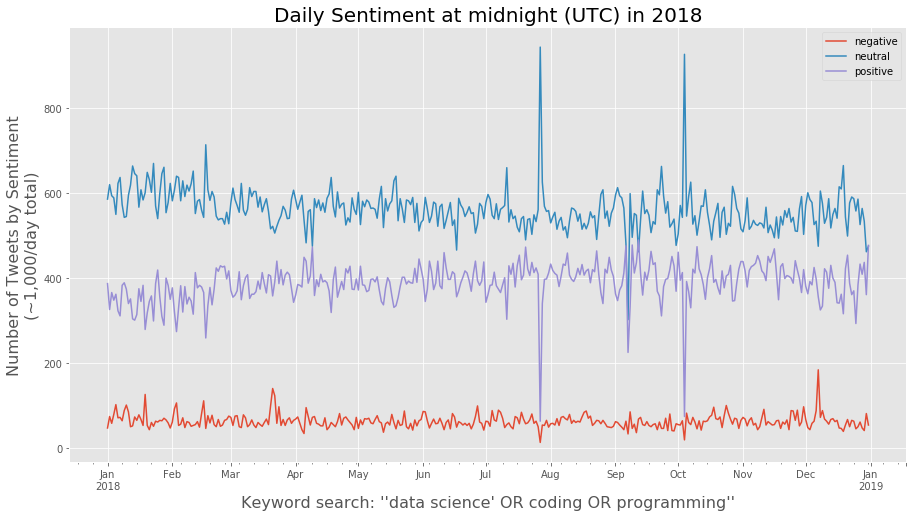

In [8]:
plot_sentiments(csv_filename=csv_filename, year=year, positive_only=False)

,tally
timestamp,
2018-01-11,1017
2018-05-26,1017
2018-10-02,1018
2018-03-09,1018
2018-06-16,1018
2018-05-19,1018
2018-07-01,1018
2018-12-10,1018
2018-09-06,1018


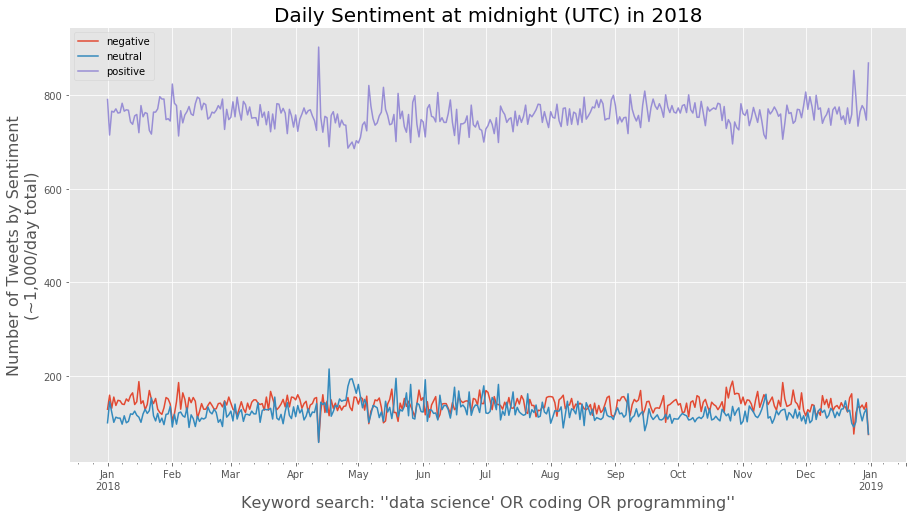

,tally
timestamp,
2018-01-13,20
2018-02-14,300
2018-04-17,680
2018-06-02,1007
2018-12-21,1017
2018-08-22,1018
2018-01-02,1018
2018-02-01,1019
2018-08-08,1019


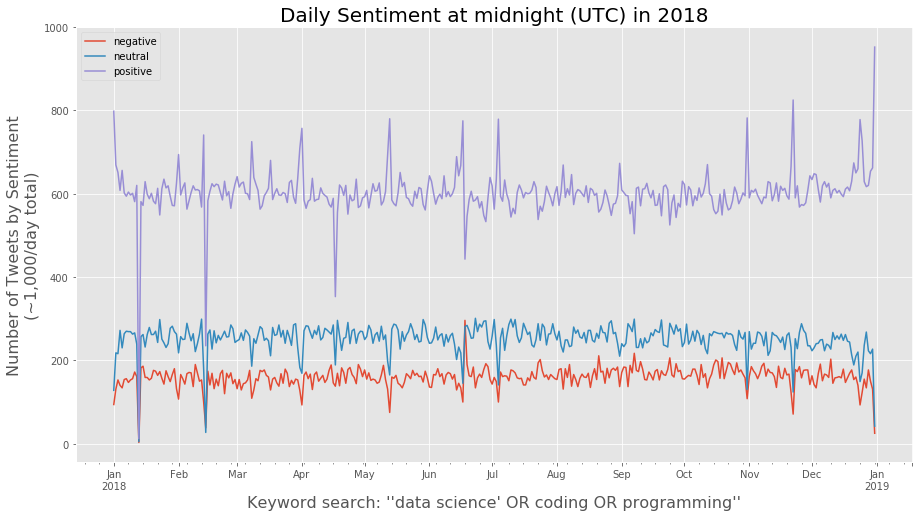

,tally
timestamp,
2018-08-05,1006
2018-04-21,1009
2018-03-04,1010
2018-03-11,1013
2018-04-10,1014
2018-03-26,1014
2018-04-13,1014
2018-03-18,1015
2018-03-21,1015


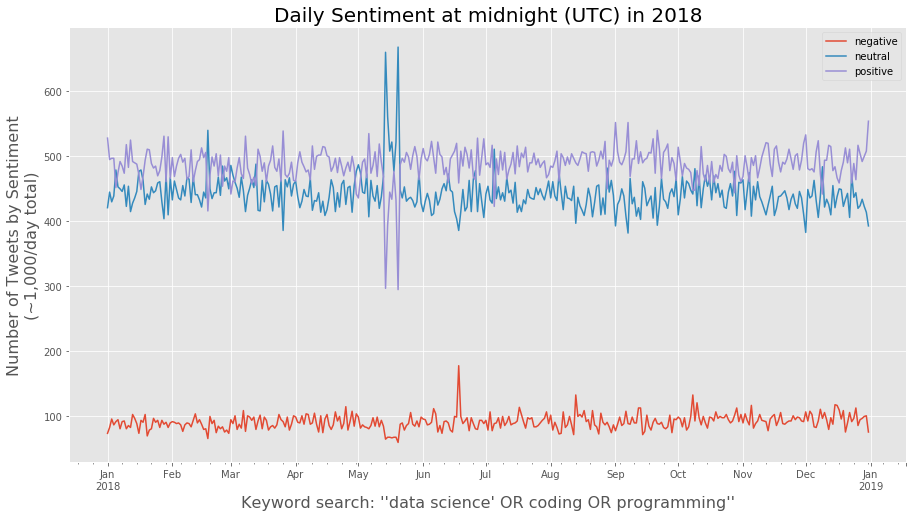

,tally
timestamp,
2018-12-07,600
2018-04-18,820
2018-02-18,900
2018-07-17,980
2018-01-10,1007
2018-08-03,1010
2018-03-04,1011
2018-08-16,1011
2018-12-19,1013


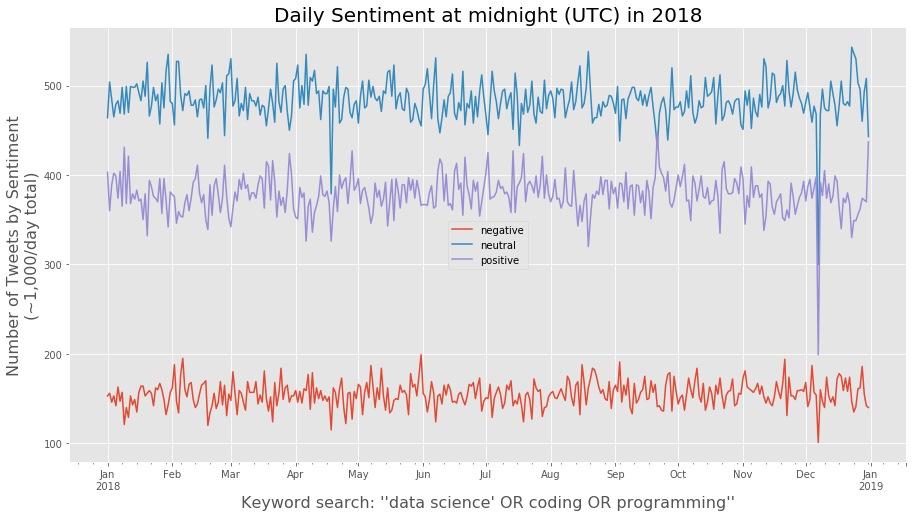

,tally
timestamp,
2018-08-01,1017
2018-10-13,1017
2018-09-16,1017
2018-11-09,1018
2018-05-06,1018
2018-09-08,1018
2018-09-14,1018
2018-07-26,1018
2018-11-04,1018


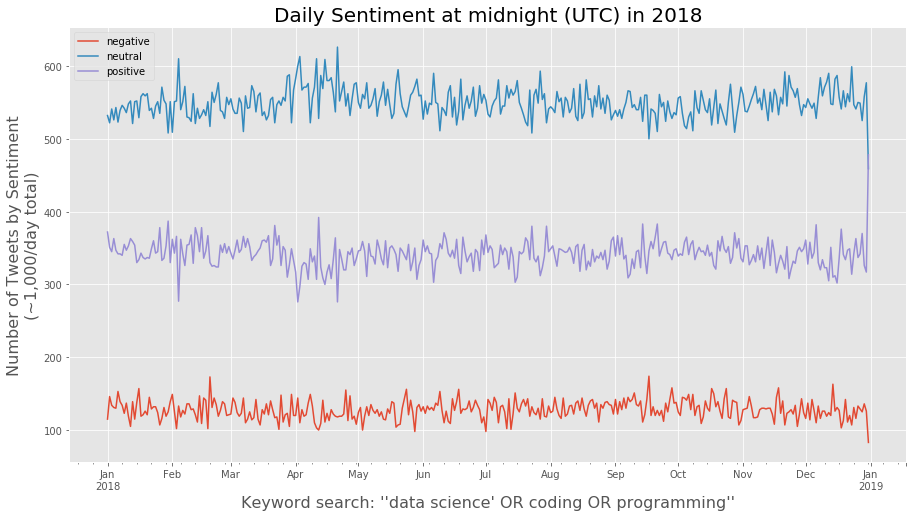

,tally
timestamp,
2018-12-30,160
2018-09-08,880
2018-10-06,1018
2018-12-31,1019
2018-06-20,1019
2018-10-18,1019
2018-03-21,1019
2018-04-30,1019
2018-02-01,1019


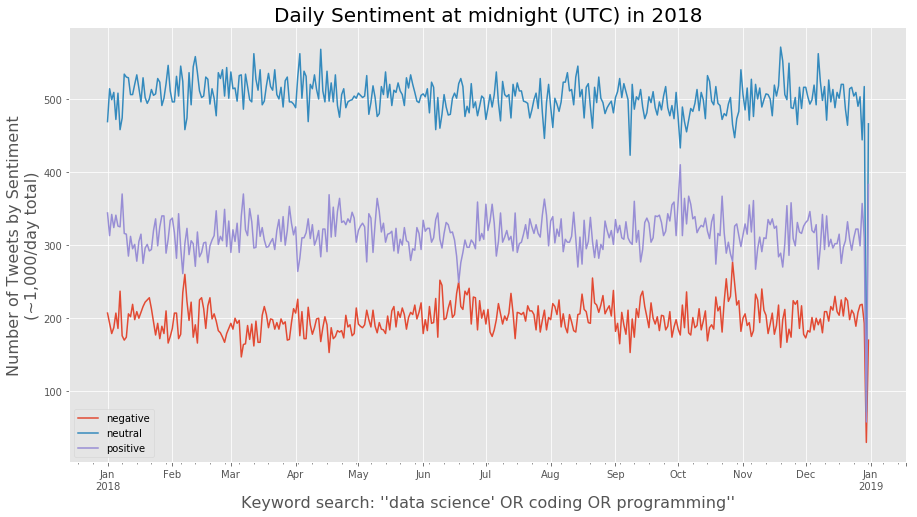

,tally
timestamp,
2018-09-07,560
2018-06-17,871
2018-05-13,893
2018-12-25,896
2018-09-30,903
2018-12-30,904
2018-11-18,908
2018-10-21,931
2018-12-16,948


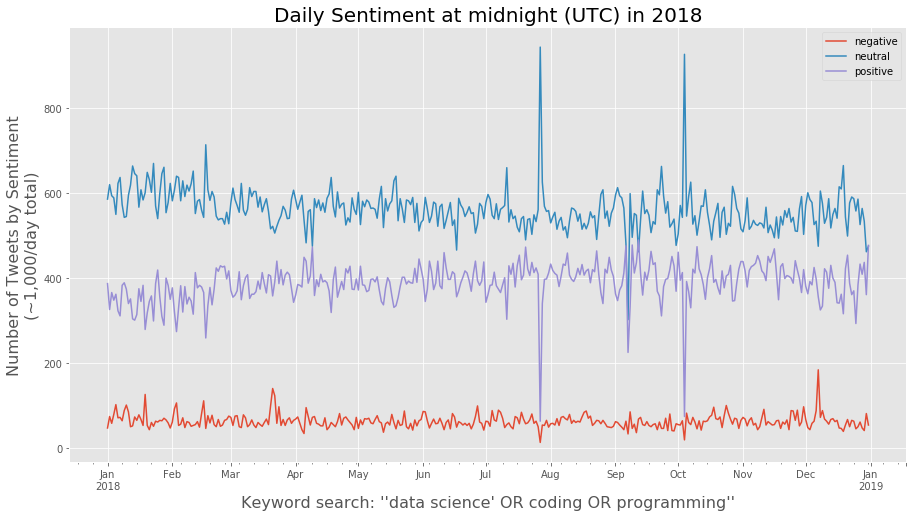

In [18]:
tweet_csv_files = ['tweets_lovehate_2018.csv',
                   'tweets_happysad_2018.csv',
                   'tweets_music_2018.csv',
                   'tweets_money_2018.csv',
                   'tweets_nowords_2018.csv',
                   'tweets_politics_2018.csv',
                   'tweets_coding_2018.csv']

for search in tweet_csv_files:
    plot_sentiments(csv_filename=search, year=2018, positive_only=False)
    plt.show();

In [42]:
# #check to see if scraper worked on all dates
# # a few missing dates is not the end of the world
# tw_df = pd.read_csv(csv_filename)
# tw_df.timestamp = pd.to_datetime(tw_df.timestamp, format='%Y%m%d')
# grouped1 = pd.DataFrame(tw_df.groupby(['timestamp'])['tally'].sum())
# grouped1 = grouped1.sort_values(by=['tally'])
# display(grouped1.head(10))

,tally
timestamp,
2018-06-19,18
2018-06-24,19
2018-03-17,20
2018-05-25,20
2018-05-08,20
2018-07-12,32
2018-07-01,35
2018-07-09,38
2018-09-30,40


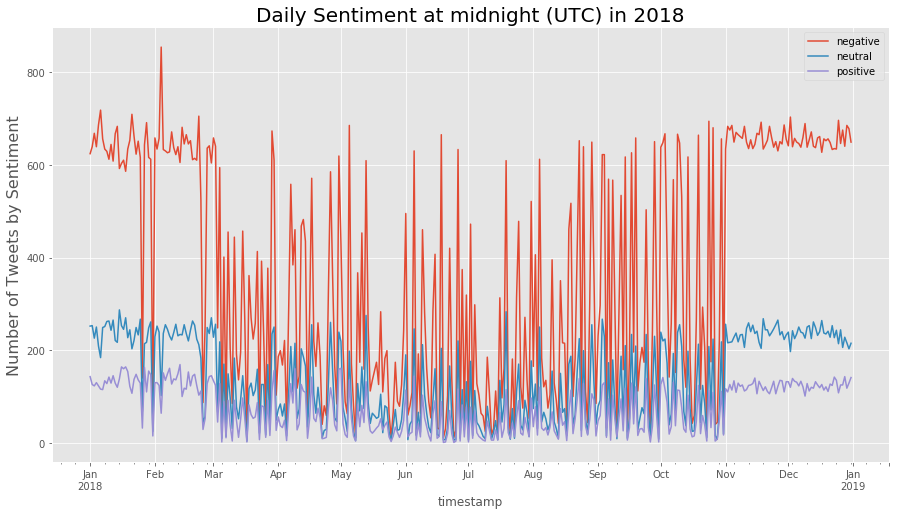

In [43]:
# # let's plot sentiment trends for our query of 2018 tweets
# grouped = pd.DataFrame(tw_df.groupby(['timestamp', 'sentiment'])['tally'].sum()).reset_index()
# for sentiment in grouped.sentiment.unique():
#     temp_df = grouped[grouped.sentiment == sentiment].set_index('timestamp')
#     temp_df['tally'].plot(figsize=(15,8), label=sentiment)
# plt.legend()
# plt.ylabel("Number of Tweets by Sentiment", fontsize=16)
# plt.xlabel(f"Keyword search: '{query}''", fontsize=16)
# plt.title(f"Daily Sentiment at midnight (UTC) in {year}", fontsize=20);